# Traffic Prediction: From Baseline to Multi-Layer Birectional LSTM model

In [157]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten, Reshape




mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [104]:
data = pd.read_csv('/kaggle/input/csc-578-final-project-spring-2024/Metro_Interstate_reduced.csv')

# EDA

In [105]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [106]:
# Summary stats
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.316763,0.318632,0.000117,44.199162,3290.650474
std,13.816618,48.812640,0.005676,38.683447,1984.772909
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.840000,0.000000,0.000000,1.000000,1248.500000
50%,282.860000,0.000000,0.000000,40.000000,3427.000000
75%,292.280000,0.000000,0.000000,90.000000,4952.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [107]:
print(data.isnull().sum())

holiday                40522
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64


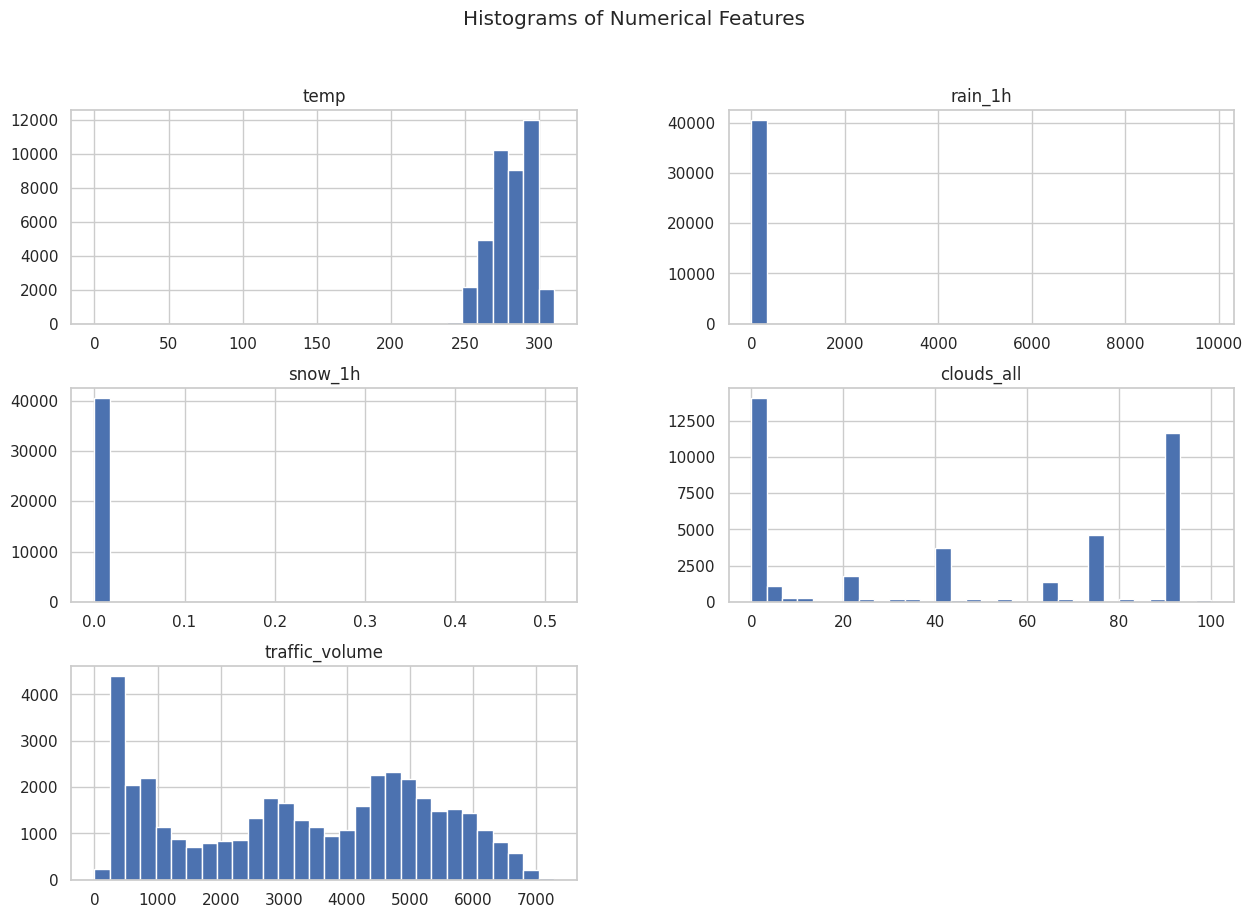

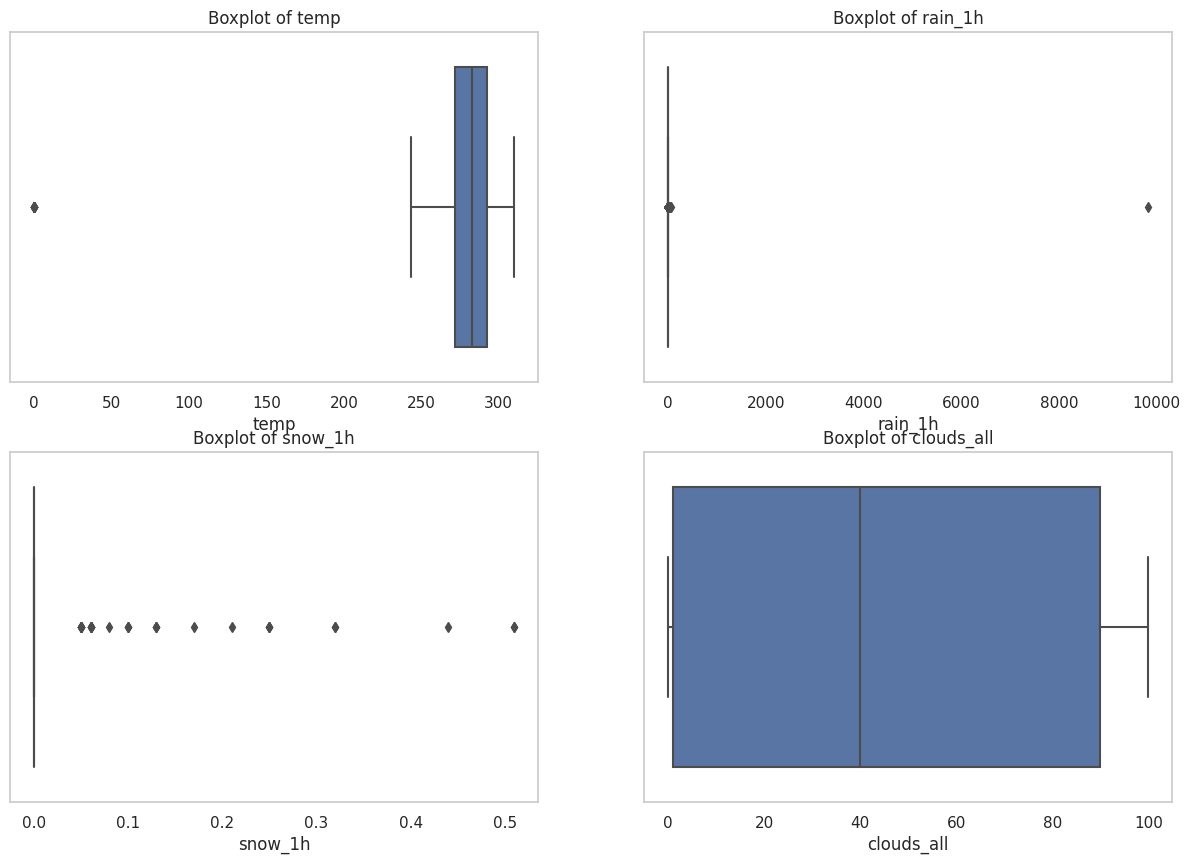

In [108]:
# Histograms
data[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(['temp', 'rain_1h', 'snow_1h', 'clouds_all']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


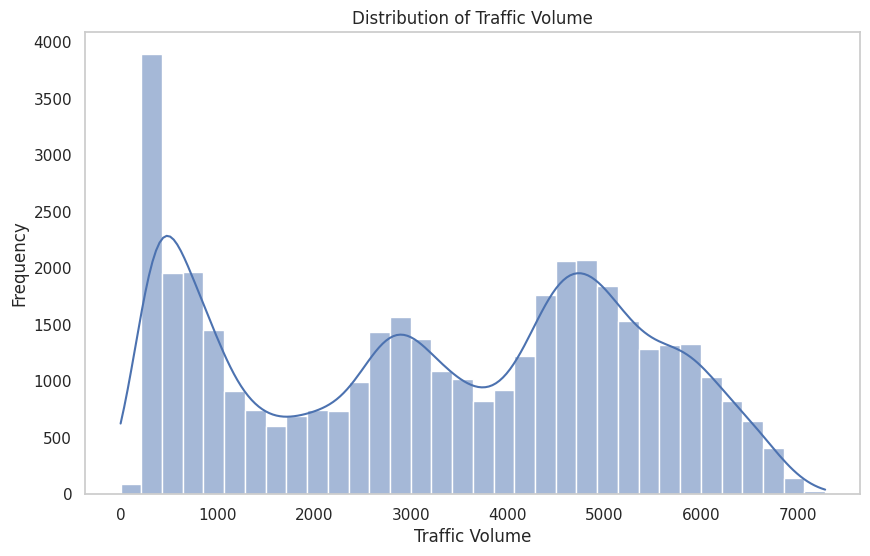

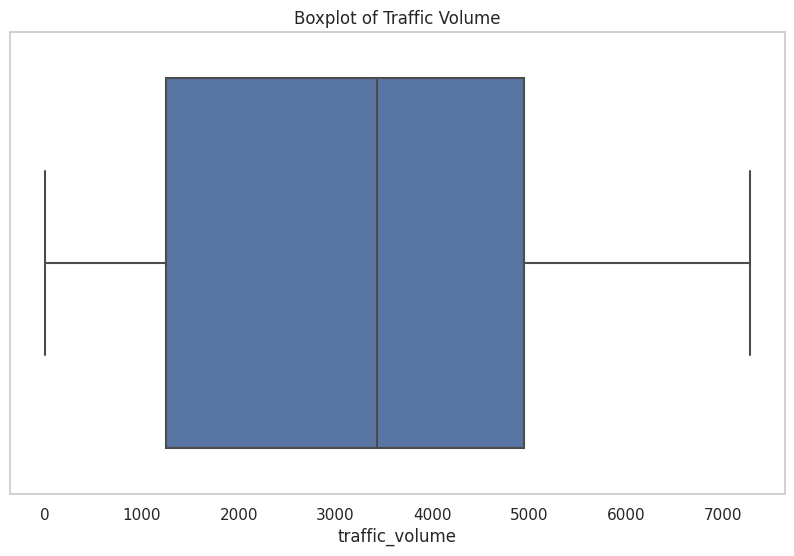

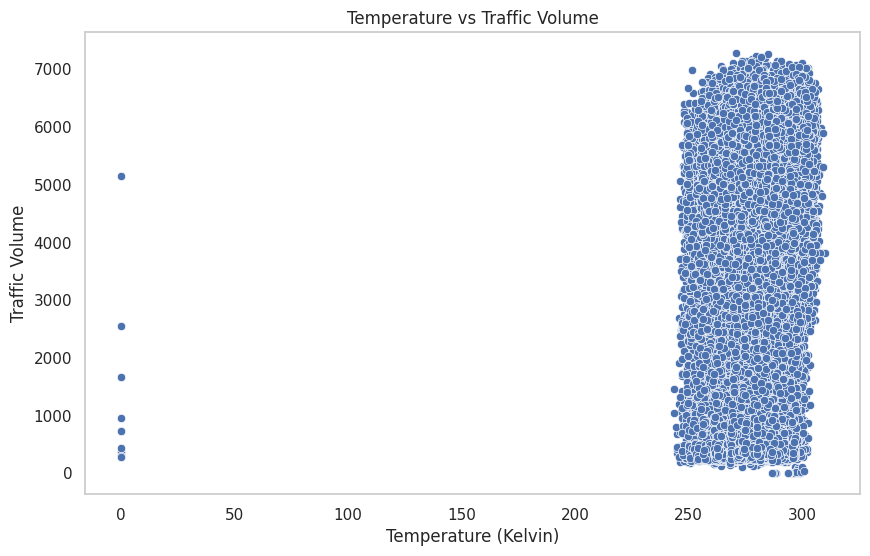

In [109]:
# Exploring the distribution of the target variable (assuming 'traffic_volume' is the target)
plt.figure(figsize=(10, 6))
sns.histplot(data['traffic_volume'], kde=True)
plt.title('Distribution of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')

# Creating a boxplot to identify any outliers in traffic volume
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['traffic_volume'])
plt.title('Boxplot of Traffic Volume')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='traffic_volume', data=data)
plt.title('Temperature vs Traffic Volume')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Traffic Volume')

plt.show()

Rain 1h - Descriptive Statistics:
count    40575.000000
mean         0.318632
std         48.812640
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9831.300000
Name: rain_1h, dtype: float64


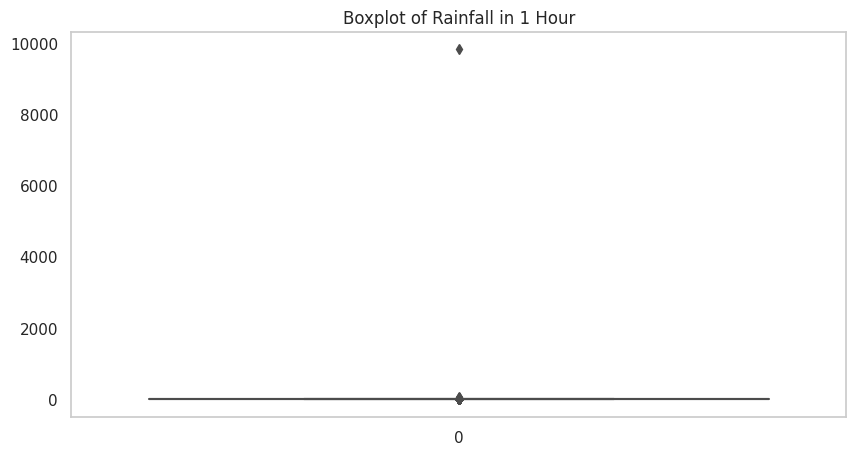

Number of non-zero rainfall entries: 2054


In [110]:
# Investigating extreme values in 'rain_1h'
print("Rain 1h - Descriptive Statistics:")
print(data['rain_1h'].describe())

# Plotting the distribution of 'rain_1h' to identify outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data['rain_1h'])
plt.title('Boxplot of Rainfall in 1 Hour')
plt.show()

non_zero_rain_counts = (data['rain_1h'] > 0).sum()
print("Number of non-zero rainfall entries:", non_zero_rain_counts)

Snow 1h - Descriptive Statistics:
count    40575.000000
mean         0.000117
std          0.005676
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.510000
Name: snow_1h, dtype: float64


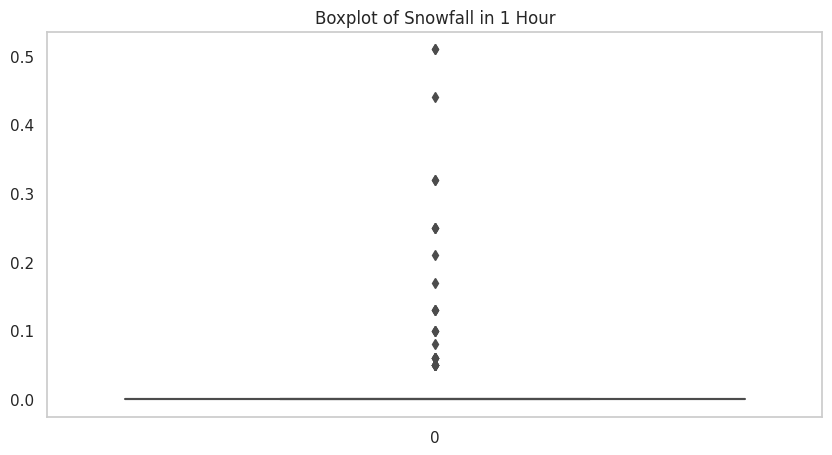

Number of non-zero snowfall entries: 31


In [111]:
# Investigating extreme values in 'snow_1h'
print("Snow 1h - Descriptive Statistics:")
print(data['snow_1h'].describe())

# Plotting the distribution of 'snow_1h' to identify outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data['snow_1h'])
plt.title('Boxplot of Snowfall in 1 Hour')
plt.show()

# Counting non-zero snowfall entries
non_zero_snow_counts = (data['snow_1h'] > 0).sum()
print("Number of non-zero snowfall entries:", non_zero_snow_counts)

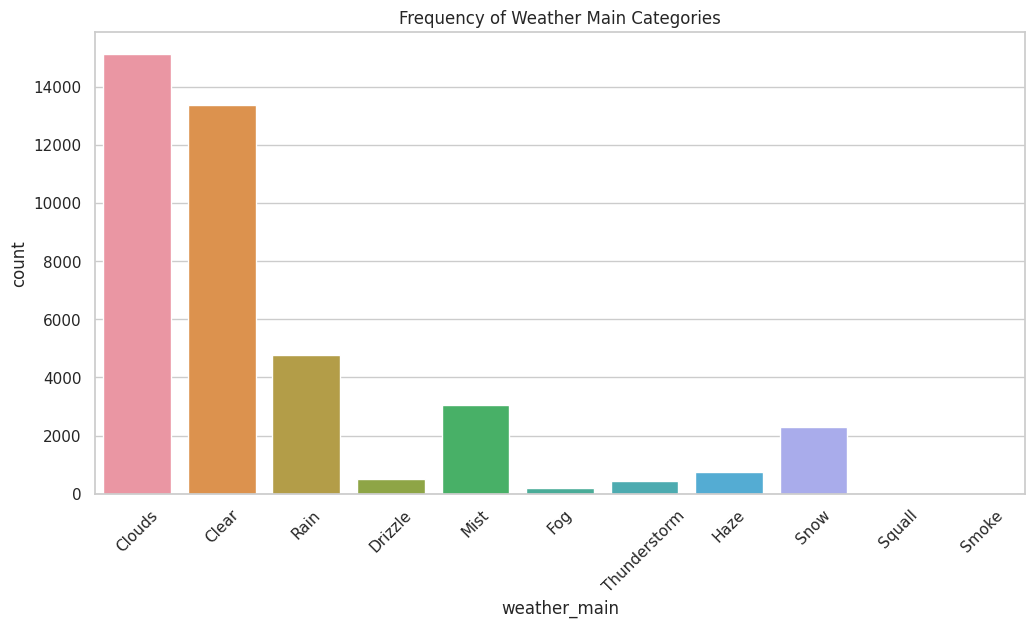

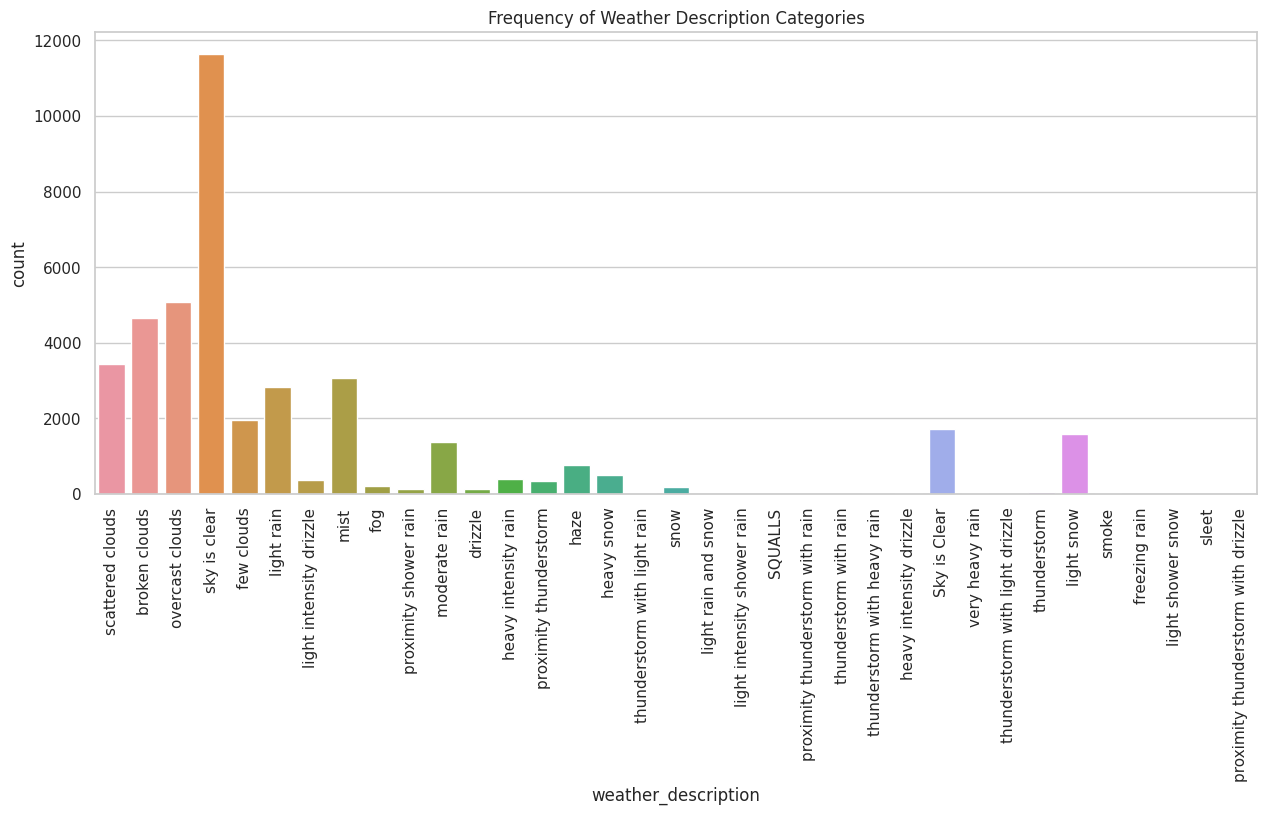

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


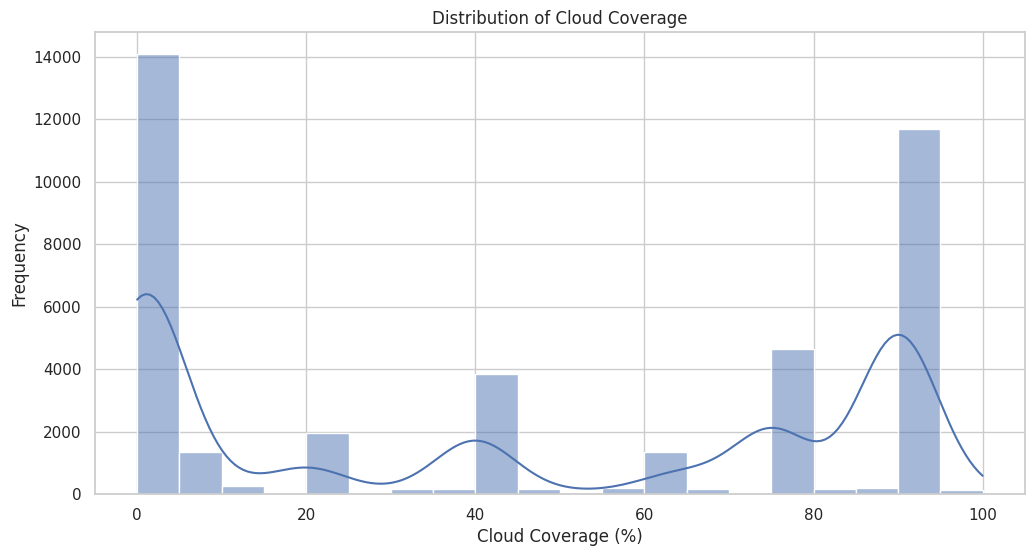

In [112]:
sns.set(style="whitegrid")

# Analyzing 'weather_main'
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='weather_main')
plt.title('Frequency of Weather Main Categories')
plt.xticks(rotation=45)
plt.show()

# Analyzing 'weather_description'
plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='weather_description')
plt.title('Frequency of Weather Description Categories')
plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.show()

# Analyzing 'clouds_all'
plt.figure(figsize=(12, 6))
sns.histplot(data['clouds_all'], kde=True)
plt.title('Distribution of Cloud Coverage')
plt.xlabel('Cloud Coverage (%)')
plt.ylabel('Frequency')
plt.show()

plt.show()

# Cleaning

In [113]:
# Convert 'date_time' to datetime format
data['date_time'] = pd.to_datetime(data['date_time'])

In [114]:
data = pd.get_dummies(data, columns=['weather_main', 'weather_description'])

In [115]:
#Added after EDA
# Drop the 'holiday' column
data.drop('holiday', axis=1, inplace=True)

# Replace 0 Kelvin values with the median temperature
median_temp = data['temp'].median()
print(f"Median Temperature: {median_temp} K")

data['temp'].replace(0, median_temp, inplace=True)#minesotta is cold but not -273 Celcius cold...

# Verify the changes
print(data['temp'].describe())

Median Temperature: 282.86 K
count    40575.000000
mean       281.386476
std         13.091592
min        243.390000
25%        271.850000
50%        282.860000
75%        292.280000
max        310.070000
Name: temp, dtype: float64


/tmp/ipykernel_34/4206553449.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['temp'].replace(0, median_temp, inplace=True)#minesotta is cold but not -273 Celcius cold...


In [116]:
# Create new columns for hour, day, month, and year
data['hour'] = data['date_time'].dt.hour
data['day'] = data['date_time'].dt.dayofweek  # Monday=0, Sunday=6
data['month'] = data['date_time'].dt.month
data['year'] = data['date_time'].dt.year

In [117]:
# Sinusoidal encoding for cyclical features
data['sin_hour'] = np.sin(2 * np.pi * data['hour']/24)
data['cos_hour'] = np.cos(2 * np.pi * data['hour']/24)
data['sin_month'] = np.sin(2 * np.pi * data['month']/12)
data['cos_month'] = np.cos(2 * np.pi * data['month']/12)

# Drop the original 'date_time' if no longer needed
data.drop('date_time', axis=1, inplace=True)

In [118]:
rain_99th_percentile = data['rain_1h'].quantile(0.99)
print(f"99th Percentile of Rainfall: {rain_99th_percentile} mm")

# Cap values at the 99th percentile
data['rain_1h'] = data['rain_1h'].clip(upper=rain_99th_percentile)

99th Percentile of Rainfall: 1.78 mm


**after capping the rain variable we still see there is a significant skew towards zero and rain itself is infrequent. It makes conceptual common sense that its that way... On the bright side the outliers (which were likely errors) were handled effectively**

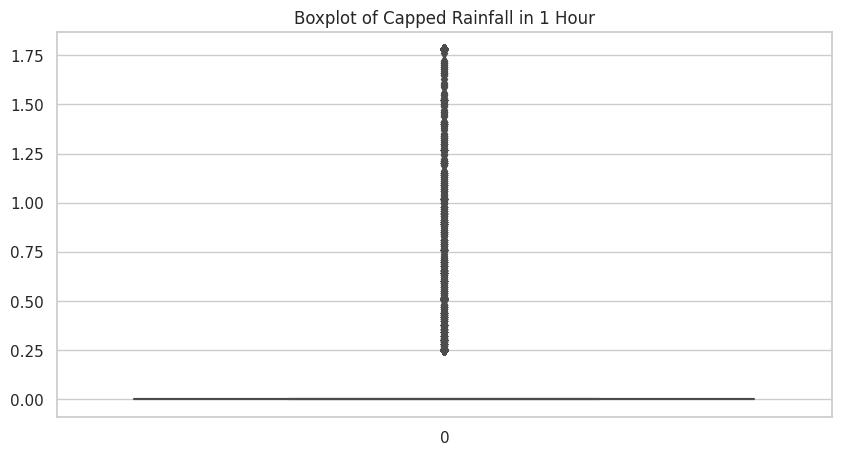

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


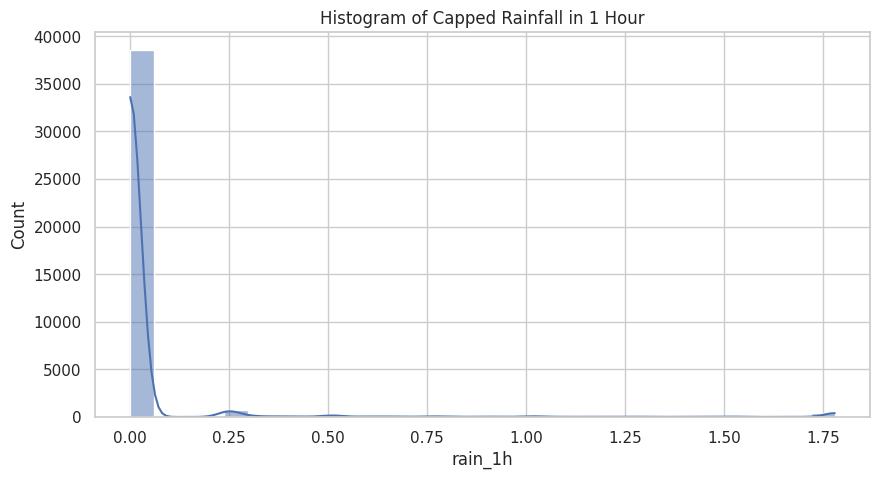

In [119]:
# Visualize the capped 'rain_1h' data
plt.figure(figsize=(10, 5))
sns.boxplot(data['rain_1h'])
plt.title('Boxplot of Capped Rainfall in 1 Hour')
plt.show()

# Histogram of capped 'rain_1h'
plt.figure(figsize=(10, 5))
sns.histplot(data['rain_1h'], bins=30, kde=True)
plt.title('Histogram of Capped Rainfall in 1 Hour')
plt.show()

The correlation between capped rain and traffic volume is: -0.0066747092806836005


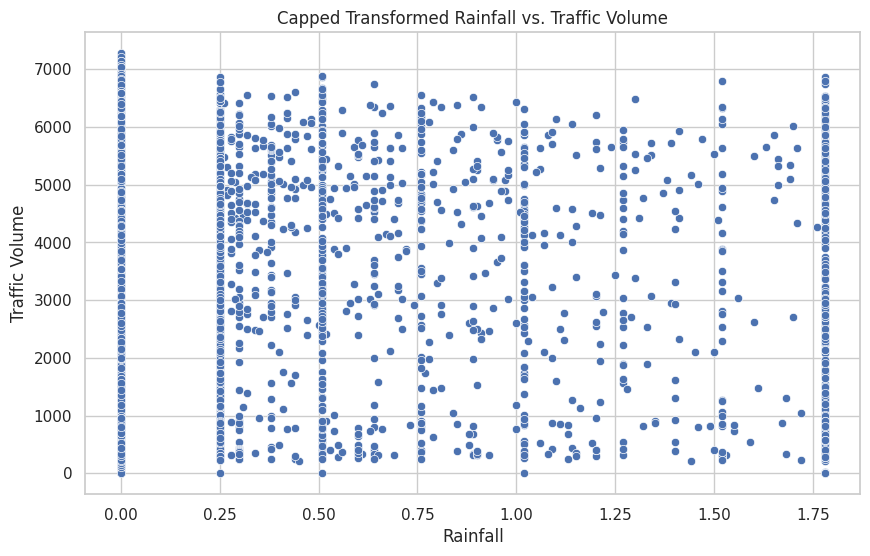

In [120]:
correlation = data['rain_1h'].corr(data['traffic_volume'])
print(f"The correlation between capped rain and traffic volume is: {correlation}")

# Step 3: Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rain_1h', y='traffic_volume', data=data)
plt.title('Capped Transformed Rainfall vs. Traffic Volume')
plt.xlabel('Rainfall')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

**How about rain vs no rain variable**

The correlation between presence of rain and traffic volume is: 0.004175937441268289


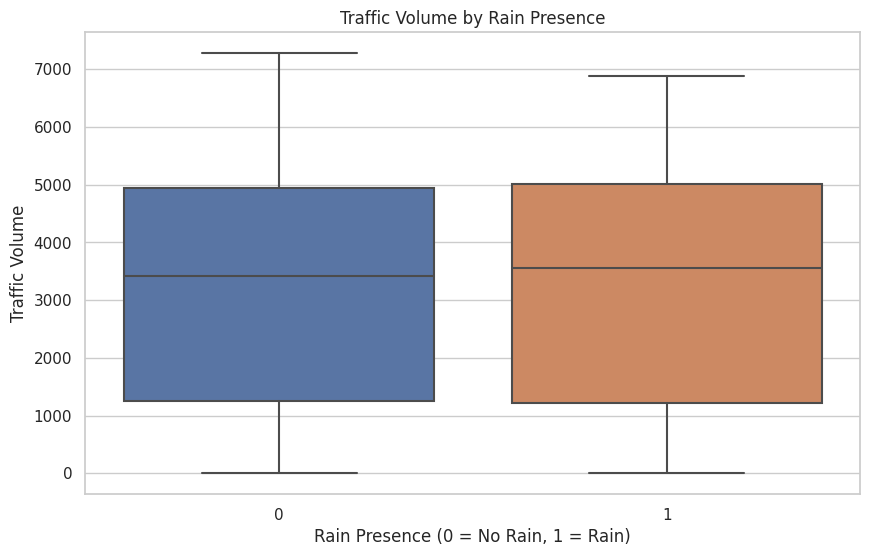

In [121]:
# Creating a binary rain indicator
data['rain_present'] = (data['rain_1h'] > 0).astype(int)

# Calculating correlation with traffic volume
correlation_binary_rain = data['rain_present'].corr(data['traffic_volume'])
print(f"The correlation between presence of rain and traffic volume is: {correlation_binary_rain}")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.boxplot(x='rain_present', y='traffic_volume', data=data)
plt.title('Traffic Volume by Rain Presence')
plt.xlabel('Rain Presence (0 = No Rain, 1 = Rain)')
plt.ylabel('Traffic Volume')
plt.show()

In [122]:
"""# Removing the log_rain_1h variable definitely will introduce unncessecary complexity with the crazy skewness it has
# also we might remvoe rain all together because it is so negligibly correlated
data.drop('log_rain_1h', axis=1, inplace=True)"""

"# Removing the log_rain_1h variable definitely will introduce unncessecary complexity with the crazy skewness it has\n# also we might remvoe rain all together because it is so negligibly correlated\ndata.drop('log_rain_1h', axis=1, inplace=True)"

In [123]:
# Calculating the correlation matrix
corr = data.corr()

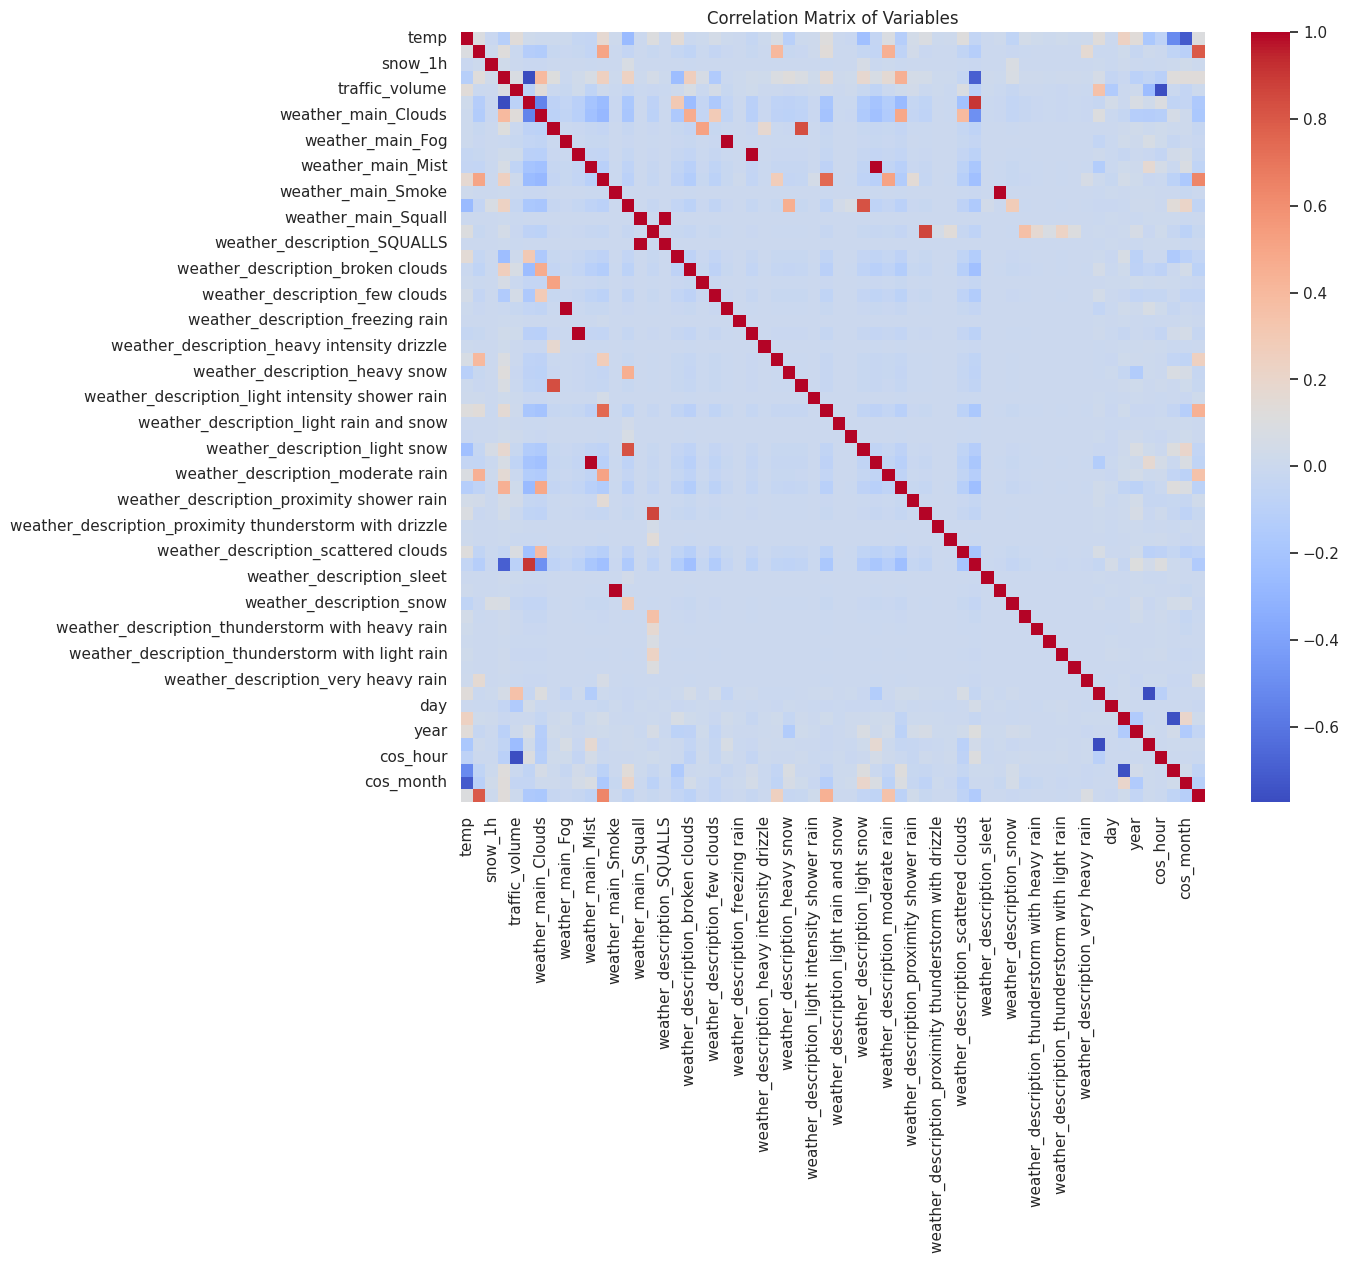

In [124]:
# Creating the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()

**we can see there is a lot of weak correlation. lets use this data set for the first model, but we might adjust later if results are poor. We can see some evidence of multicolliniearity, but RNNs are robust and we will tackle with regularization techniques**

In [125]:
# Display the first few rows of the dataset
print(data.head())

     temp  rain_1h  snow_1h  clouds_all  traffic_volume  weather_main_Clear  \
0  288.28      0.0      0.0          40            5545               False   
1  289.36      0.0      0.0          75            4516               False   
2  289.58      0.0      0.0          90            4767               False   
3  290.13      0.0      0.0          90            5026               False   
4  291.14      0.0      0.0          75            4918               False   

   weather_main_Clouds  weather_main_Drizzle  weather_main_Fog  \
0                 True                 False             False   
1                 True                 False             False   
2                 True                 False             False   
3                 True                 False             False   
4                 True                 False             False   

   weather_main_Haze  ...  weather_description_very heavy rain  hour  day  \
0              False  ...                          

Let's take a glance at the data. Here are the first few rows:

In [126]:
# Summary stats
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,day,month,year,sin_hour,cos_hour,sin_month,cos_month,rain_present
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,4.057500e+04,4.057500e+04,4.057500e+04,40575.000000
mean,281.386476,0.041438,0.000117,44.199162,3290.650474,11.514750,3.006778,6.489045,2015.479729,-0.001680,5.320098e-03,-8.509186e-03,-4.366938e-02,0.050622
std,13.091592,0.226512,0.005676,38.683447,1984.772909,6.949889,1.998947,3.373618,1.888817,0.705984,7.082228e-01,7.018118e-01,7.109890e-01,0.219228
min,243.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2012.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000
25%,271.850000,0.000000,0.000000,1.000000,1248.500000,5.000000,1.000000,4.000000,2014.000000,-0.707107,-7.071068e-01,-5.000000e-01,-8.660254e-01,0.000000
50%,282.860000,0.000000,0.000000,40.000000,3427.000000,12.000000,3.000000,7.000000,2016.000000,0.000000,6.123234e-17,-2.449294e-16,-1.836970e-16,0.000000
75%,292.280000,0.000000,0.000000,90.000000,4952.000000,18.000000,5.000000,9.000000,2017.000000,0.707107,7.071068e-01,5.000000e-01,5.000000e-01,0.000000
max,310.070000,1.780000,0.510000,100.000000,7280.000000,23.000000,6.000000,12.000000,2018.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000


In [127]:
# Checking for missing values
print(data.isnull().sum())

temp                                                       0
rain_1h                                                    0
snow_1h                                                    0
clouds_all                                                 0
traffic_volume                                             0
weather_main_Clear                                         0
weather_main_Clouds                                        0
weather_main_Drizzle                                       0
weather_main_Fog                                           0
weather_main_Haze                                          0
weather_main_Mist                                          0
weather_main_Rain                                          0
weather_main_Smoke                                         0
weather_main_Snow                                          0
weather_main_Squall                                        0
weather_main_Thunderstorm                                  0
weather_description_SQUA

In [128]:
print(data.head())

     temp  rain_1h  snow_1h  clouds_all  traffic_volume  weather_main_Clear  \
0  288.28      0.0      0.0          40            5545               False   
1  289.36      0.0      0.0          75            4516               False   
2  289.58      0.0      0.0          90            4767               False   
3  290.13      0.0      0.0          90            5026               False   
4  291.14      0.0      0.0          75            4918               False   

   weather_main_Clouds  weather_main_Drizzle  weather_main_Fog  \
0                 True                 False             False   
1                 True                 False             False   
2                 True                 False             False   
3                 True                 False             False   
4                 True                 False             False   

   weather_main_Haze  ...  weather_description_very heavy rain  hour  day  \
0              False  ...                          

****

## Train, Test, Val Split

In [129]:
train_df = data.iloc[:35575]
test_df = data.iloc[35575:40575]

# Optional: Create a validation set from the last portion of the training set
validation_size = int(0.1 * len(train_df))  # 10% of training data
val_df = train_df.iloc[-validation_size:]
train_df = train_df.iloc[:-validation_size]

In [130]:
# Print the number of instances in each dataset to confirm sizes
print("Number of instances in:")
print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Number of instances in:
Training set: 32018
Validation set: 3557
Test set: 5000


## Normalize data

In [131]:
scaler = StandardScaler()

In [132]:
# Normalize the 'traffic_volume' using only the training set
train_df['traffic_volume'] = scaler.fit_transform(train_df[['traffic_volume']])

In [133]:
# Apply the same transformation to the validation and test sets
val_df['traffic_volume'] = scaler.transform(val_df[['traffic_volume']])
test_df['traffic_volume'] = scaler.transform(test_df[['traffic_volume']])

/tmp/ipykernel_34/3299650471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['traffic_volume'] = scaler.transform(test_df[['traffic_volume']])


**Data windowing**

In [134]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes manually.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                # Adjusting prediction index to match label_indices
                # Assuming label indices point to the last step in each sequence for prediction
                plt.scatter(self.label_indices, predictions[n, -1, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        plt.show()
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])



    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [135]:
# Assume 'traffic_volume' is the label we want to predict
label_column = ['traffic_volume']

# Create the WindowGenerator object
w1 = WindowGenerator(input_width=12, label_width=1, shift=3,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=label_column)

print(w1)

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [14]
Label column name(s): ['traffic_volume']


In [136]:
example_inputs, example_labels = next(iter(w1.train))
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


Inputs shape: (32, 12, 60)
Labels shape: (32, 1, 1)


## Baseline Model

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5398 - mean_absolute_error: 1.3660
Validation performance: {'loss': 2.3805506229400635, 'mean_absolute_error': 1.3181401491165161}
Test performance: {'loss': 2.450911521911621, 'mean_absolute_error': 1.3377219438552856}


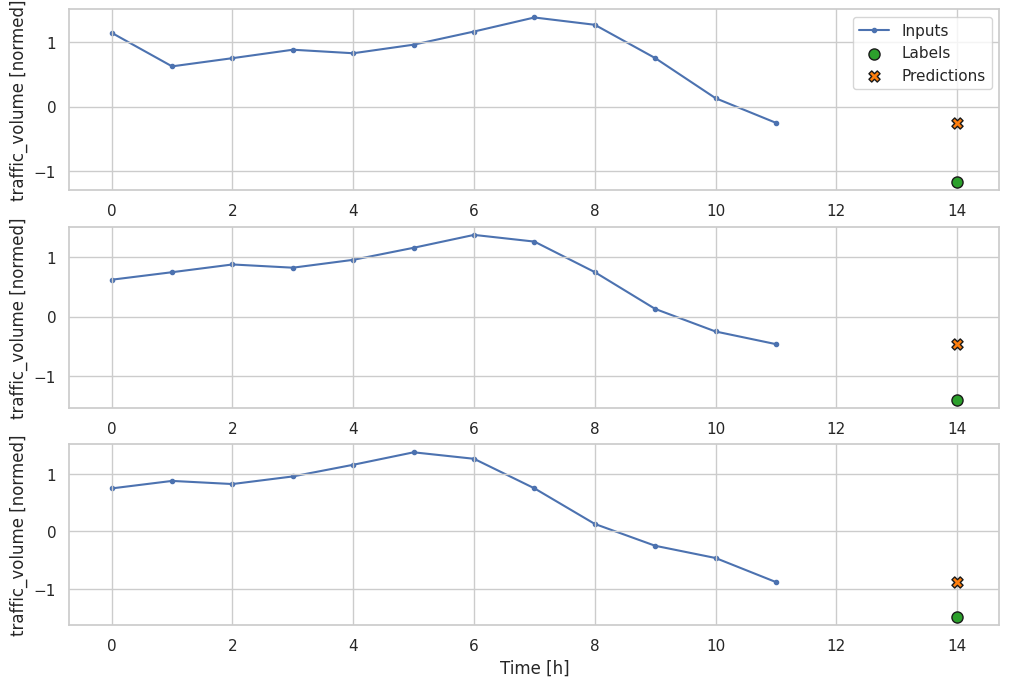

In [137]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

# Assuming 'traffic_volume' is the label we want to predict
label_column_index = w1.column_indices['traffic_volume']
baseline = Baseline(label_index=label_column_index)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Evaluate the baseline model
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w1.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Baseline']}")
print(f"Test performance: {performance['Baseline']}")

w1.plot(baseline)


## BASELINE LSTM RNN

In [138]:
#Early stopping to prevent overfitting in case i want to add it later
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# lr scheduler to reduce on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0417 - mean_absolute_error: 0.8946 - val_loss: 0.9866 - val_mean_absolute_error: 0.8651 - learning_rate: 0.0010
Epoch 2/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0223 - mean_absolute_error: 0.8884 - val_loss: 0.9865 - val_mean_absolute_error: 0.8650 - learning_rate: 0.0010
Epoch 3/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0222 - mean_absolute_error: 0.8884 - val_loss: 0.9864 - val_mean_absolute_error: 0.8650 - learning_rate: 0.0010
Epoch 4/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0221 - mean_absolute_error: 0.8883 - val_loss: 0.9864 - val_mean_absolute_error: 0.8650 - learning_rate: 0.0010
Epoch 5/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0221 - mean_absolute_error: 0.8883 - val_loss: 0.9863 - val_mean_absolute_error: 0.8650 - learning_rate: 0.0010
Epoch 6/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0220 - mean_absolute_error: 0.8883 - val_loss: 0.9863 - 

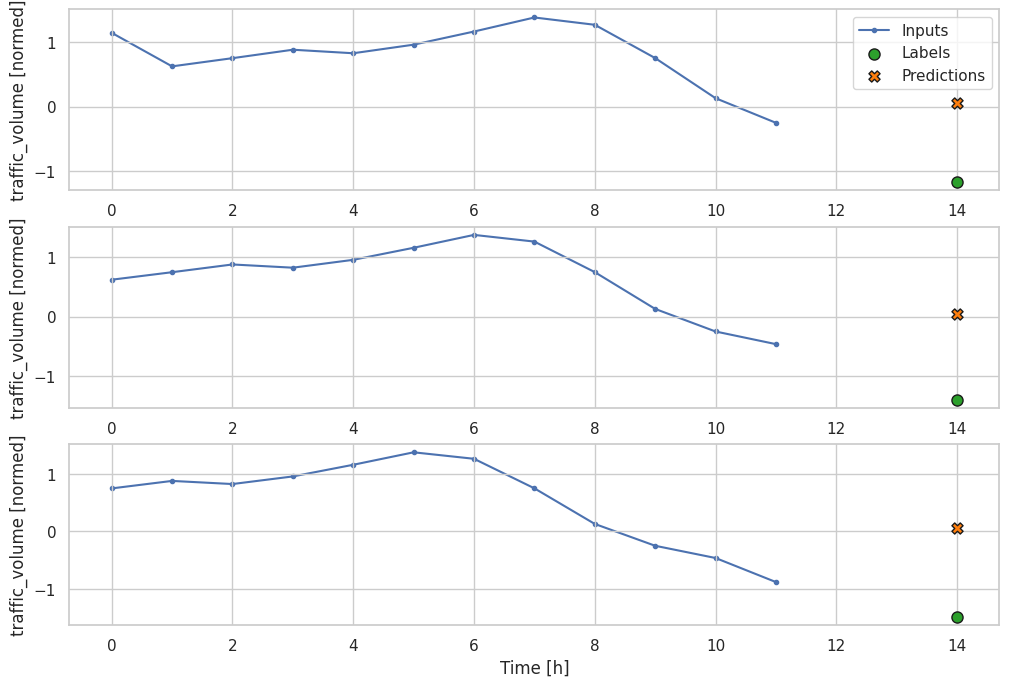

In [139]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(w1.input_width, len(train_df.columns))),
    tf.keras.layers.Dense(units=1)
])

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the LSTM model
history = lstm_model.fit(w1.train, epochs=20,
                         validation_data=w1.val,
                         callbacks=[reduce_lr])

# Evaluate the LSTM model
val_performance['LSTM'] = lstm_model.evaluate(w1.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['LSTM']}")
print(f"Test performance: {performance['LSTM']}")

w1.plot(lstm_model)


**baseline model evaluation**

In [140]:
def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot training & validation MAE values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

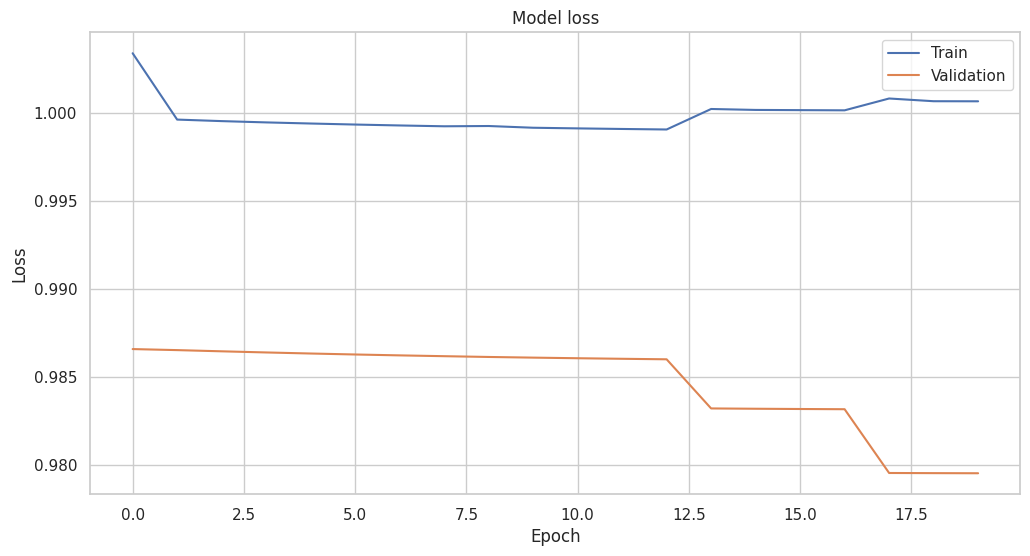

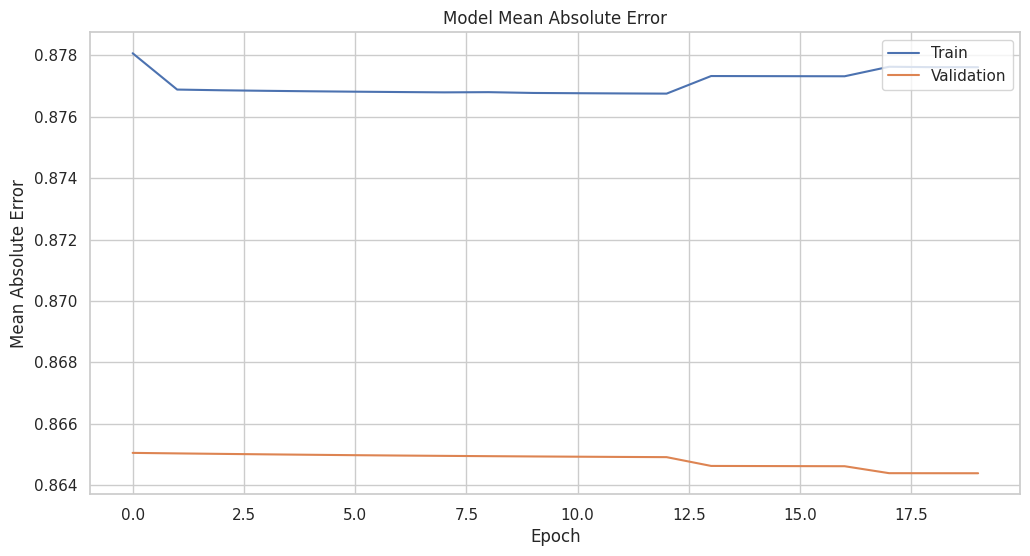

In [141]:
plot_training_history(history)

**Significant underfitting and obvious lack of improvement over epochs. need to increase complexity**

**Lets add more units and dropout layers first**

In [142]:
complexNoDO_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(12, len(train_df.columns))),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

complexNoDO_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the improved LSTM model
history_ComplxPlusDO = complexNoDO_lstm_model.fit(w1.train, epochs=20,
                                           validation_data=w1.val,
                                           callbacks=[reduce_lr])

Epoch 1/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.0279 - mean_absolute_error: 0.8897 - val_loss: 0.9850 - val_mean_absolute_error: 0.8648 - learning_rate: 0.0010
Epoch 2/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0210 - mean_absolute_error: 0.8877 - val_loss: 0.9853 - val_mean_absolute_error: 0.8648 - learning_rate: 0.0010
Epoch 3/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0204 - mean_absolute_error: 0.8876 - val_loss: 0.9864 - val_mean_absolute_error: 0.8650 - learning_rate: 0.0010
Epoch 4/20
 998/1001 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0207 - mean_absolute_error: 0.8878
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0206 - mean_absolute_error: 0.8878 - val_loss: 0.9862 - val_mean_absolute_error: 0.8649 - learning_rate: 0.0010
Epoch 5/20
 580/1001 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0336 - mean_absolute_error: 0.8942

KeyboardInterrupt: 

In [ ]:
w1.plot(complexNoDO_lstm_model)

# Evaluate the improved LSTM model
val_performance['Improved_LSTM'] = complexNoDO_lstm_model.evaluate(w1.val, return_dict=True)
performance['Improved_LSTM'] = complexNoDO_lstm_model.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Improved_LSTM']}")
print(f"Test performance: {performance['Improved_LSTM']}")

plot_training_history(history_ComplxPlusDO)

Much better results than baseline

**Reducing the LR rate**

In [ ]:
complexPlus_lstm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(12, len(train_df.columns))),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
complexPlus_lstm_model_2.compile(loss=tf.keras.losses.MeanSquaredError(),
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the improved LSTM model
history_ComplxPlus_2 = complexPlus_lstm_model_2.fit(w1.train, epochs=20,
                                           validation_data=w1.val,
                                           callbacks=[reduce_lr])

In [ ]:
w1.plot(complexPlus_lstm_model_2)

# Evaluate the improved LSTM model
val_performance['Improved_LSTM'] = complexPlus_lstm_model_2.evaluate(w1.val, return_dict=True)
performance['Improved_LSTM'] = complexPlus_lstm_model_2.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Improved_LSTM']}")
print(f"Test performance: {performance['Improved_LSTM']}")

plot_training_history(history_ComplxPlus_2)

**Adding Dropout layers to reduce overfitting**

In [ ]:
complexPlus_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(12, len(train_df.columns))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

complexPlus_lstm_model_1.compile(loss=tf.keras.losses.MeanSquaredError(),
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the improved LSTM model
history_ComplxPlus_1 = complexPlus_lstm_model_1.fit(w1.train, epochs=20,
                                           validation_data=w1.val,
                                           callbacks=[reduce_lr])

w1.plot(complexPlus_lstm_model_1)

# Evaluate the improved LSTM model
val_performance['Improved_LSTM'] = complexPlus_lstm_model_1.evaluate(w1.val, return_dict=True)
performance['Improved_LSTM'] = complexPlus_lstm_model_1.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Improved_LSTM']}")
print(f"Test performance: {performance['Improved_LSTM']}")

plot_training_history(history_ComplxPlus_1)

**Wild... lets adjust scheduler**

In [ ]:
reduce_lr_p5 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)


In [ ]:
complexPlus_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(12, len(train_df.columns))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

complexPlus_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the improved LSTM model
history_ComplxPlus = complexPlus_lstm_model.fit(w1.train, epochs=20,
                                           validation_data=w1.val,
                                           callbacks=[reduce_lr_p5])

w1.plot(complexPlus_lstm_model)

# Evaluate the improved LSTM model
val_performance['Improved_LSTM'] = complexPlus_lstm_model.evaluate(w1.val, return_dict=True)
performance['Improved_LSTM'] = complexPlus_lstm_model.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Improved_LSTM']}")
print(f"Test performance: {performance['Improved_LSTM']}")

plot_training_history(history_ComplxPlus)

## **significant model improvement!**

it seems that we may not need an lr scheduler because the LR rate stayed at 0.0001, but I will keep it just in case. what if we increase number of epochs but also add an early stopping to make the training more efficient timewise

In [ ]:
complexPlus_lstm_model_ep = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(12, len(train_df.columns))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

complexPlus_lstm_model_ep.compile(loss=tf.keras.losses.MeanSquaredError(),
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the improved LSTM model
history_ComplxPlus_ep = complexPlus_lstm_model_ep.fit(w1.train, epochs=25,
                                           validation_data=w1.val,
                                           callbacks=[reduce_lr_p5])

w1.plot(complexPlus_lstm_model_ep)

# Evaluate the improved LSTM model
val_performance['Improved_LSTM'] = complexPlus_lstm_model_ep.evaluate(w1.val, return_dict=True)
performance['Improved_LSTM'] = complexPlus_lstm_model_ep.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Improved_LSTM']}")
print(f"Test performance: {performance['Improved_LSTM']}")

plot_training_history(history_ComplxPlus_ep)

**somehow its overfitting and much worse in loss parameters... lets try to make the model more complex and increase dropout**

**More complex lstm RNN**

In [ ]:
more_complex_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(12, len(train_df.columns))),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1)
])

more_complex_lstm_model_1.compile(loss=tf.keras.losses.MeanSquaredError(),
                                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                                metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the more complex LSTM model
history_more_complex_lstm_1 = more_complex_lstm_model.fit(w1.train, epochs=20,
                                                        validation_data=w1.val,
                                                        callbacks=[reduce_lr_p5, early_stopping])

w1.plot(more_complex_lstm_model_1)

val_performance['More_Complex_LSTM'] = more_complex_lstm_model_1.evaluate(w1.val, return_dict=True)
performance['More_Complex_LSTM'] = more_complex_lstm_model_1.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['More_Complex_LSTM']}")
print(f"Test performance: {performance['More_Complex_LSTM']}")

plot_training_history(history_more_complex_lstm_1)

**too much complexity, lets add regularization. now that i think about it... regularization makes a lot of sense since we saw many variables seemingly useless in the eda**

Epoch 1/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1.3479 - mean_absolute_error: 0.8706 - val_loss: 0.9664 - val_mean_absolute_error: 0.7735 - learning_rate: 1.0000e-04
Epoch 2/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.9302 - mean_absolute_error: 0.7516 - val_loss: 0.7894 - val_mean_absolute_error: 0.6910 - learning_rate: 1.0000e-04
Epoch 3/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.8332 - mean_absolute_error: 0.7065 - val_loss: 0.7245 - val_mean_absolute_error: 0.6570 - learning_rate: 1.0000e-04
Epoch 4/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.7782 - mean_absolute_error: 0.6784 - val_loss: 0.6489 - val_mean_absolute_error: 0.6151 - learning_rate: 1.0000e-04
Epoch 5/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.7242 - mean_absolute_error: 0.6502 - val_loss: 0.6042 - val_mean_absolute_error: 0.5967 - learning_rate: 1.0000e-04
Epoch 6/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.6806 - mean_absolute_error: 0.6232 

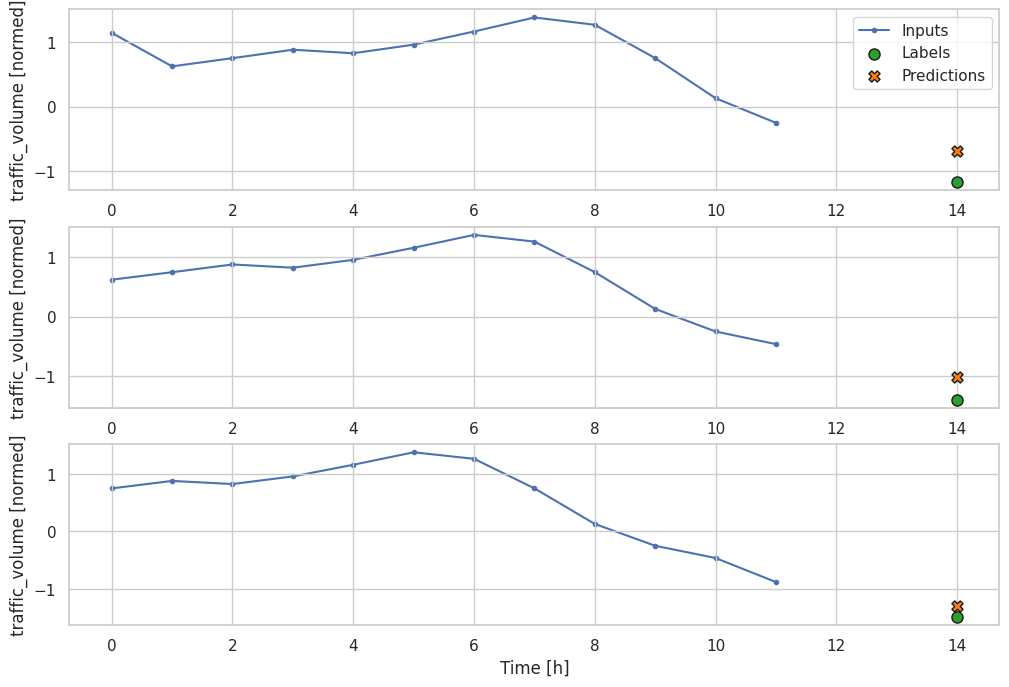

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3501 - mean_absolute_error: 0.4123
Validation performance: {'loss': 0.4190925657749176, 'mean_absolute_error': 0.469870924949646}
Test performance: {'loss': 0.32461678981781006, 'mean_absolute_error': 0.3926139175891876}


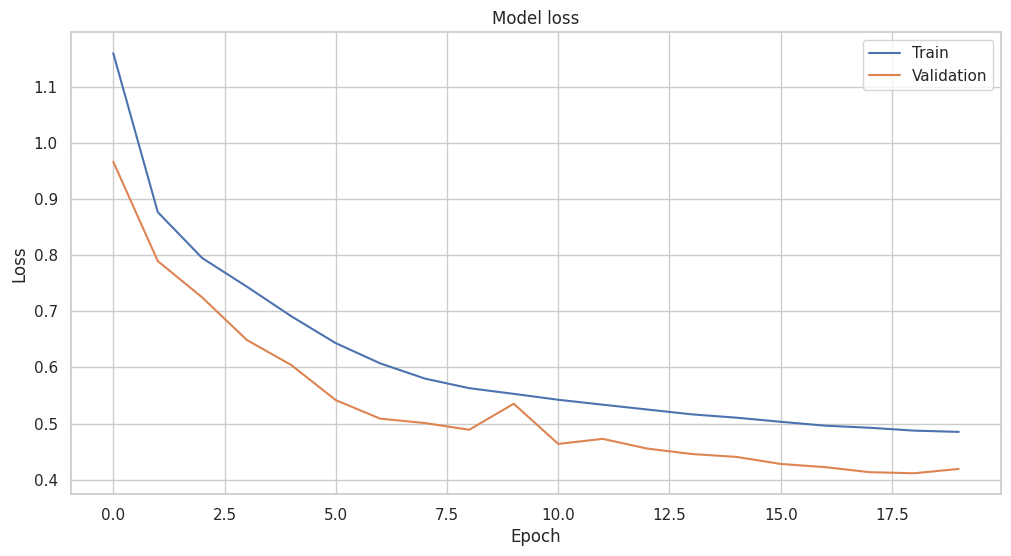

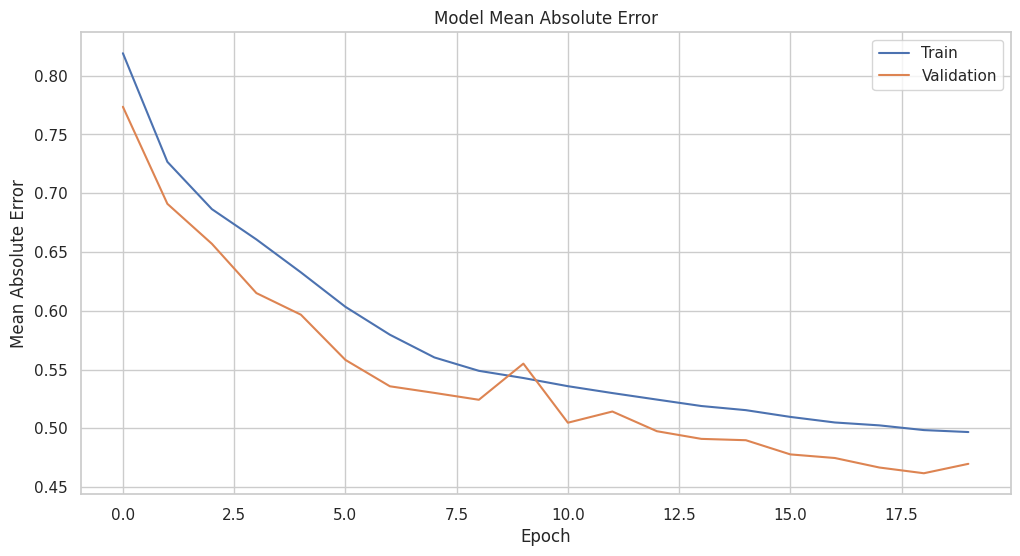

In [144]:
more_complex_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(12, len(train_df.columns)), kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, kernel_regularizer=l2(0.001))
])

more_complex_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                                metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the more complex LSTM model
history_more_complex_lstm = more_complex_lstm_model.fit(w1.train, epochs=20,
                                                        validation_data=w1.val,
                                                        callbacks=[reduce_lr_p5])

w1.plot(more_complex_lstm_model)

val_performance['More_Complex_LSTM'] = more_complex_lstm_model.evaluate(w1.val, return_dict=True)
performance['More_Complex_LSTM'] = more_complex_lstm_model.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['More_Complex_LSTM']}")
print(f"Test performance: {performance['More_Complex_LSTM']}")

plot_training_history(history_more_complex_lstm)

## **THE ABSOLUTE BEST MODEL SO FAR: Multi-layer Bidirectional LSTM model**

**Lets try bidirectional lstm**

Epoch 1/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 1.9286 - mean_absolute_error: 0.7722 - val_loss: 1.2182 - val_mean_absolute_error: 0.6871 - learning_rate: 1.0000e-04
Epoch 2/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.9332 - mean_absolute_error: 0.5701 - val_loss: 0.8771 - val_mean_absolute_error: 0.5920 - learning_rate: 1.0000e-04
Epoch 3/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.7407 - mean_absolute_error: 0.5209 - val_loss: 0.5994 - val_mean_absolute_error: 0.4748 - learning_rate: 1.0000e-04
Epoch 4/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.6210 - mean_absolute_error: 0.4786 - val_loss: 0.5180 - val_mean_absolute_error: 0.4376 - learning_rate: 1.0000e-04
Epoch 5/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.5666 - mean_absolute_error: 0.4683 - val_loss: 0.4544 - val_mean_absolute_error: 0.4226 - learning_rate: 1.0000e-04
Epoch 6/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.5190 - mean_absolute_err

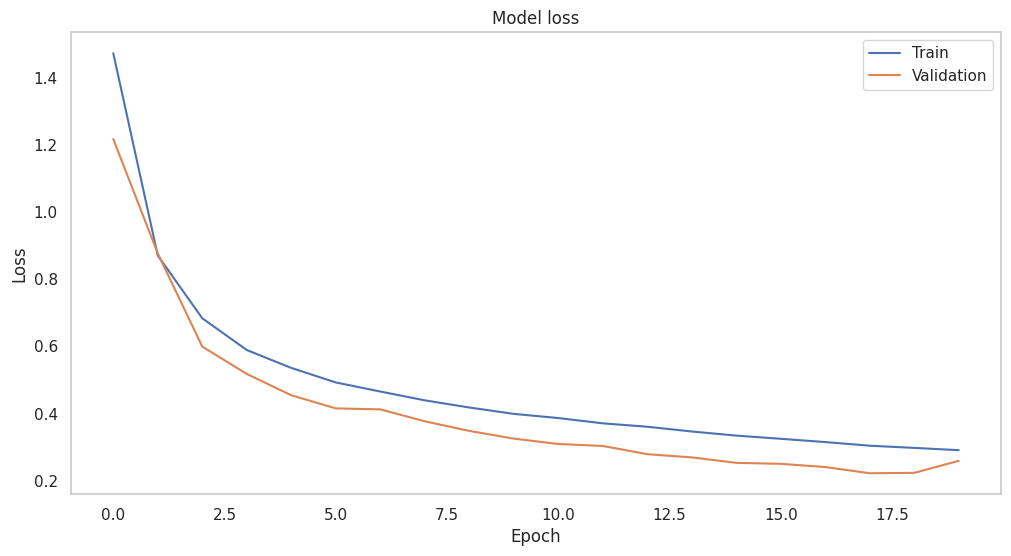

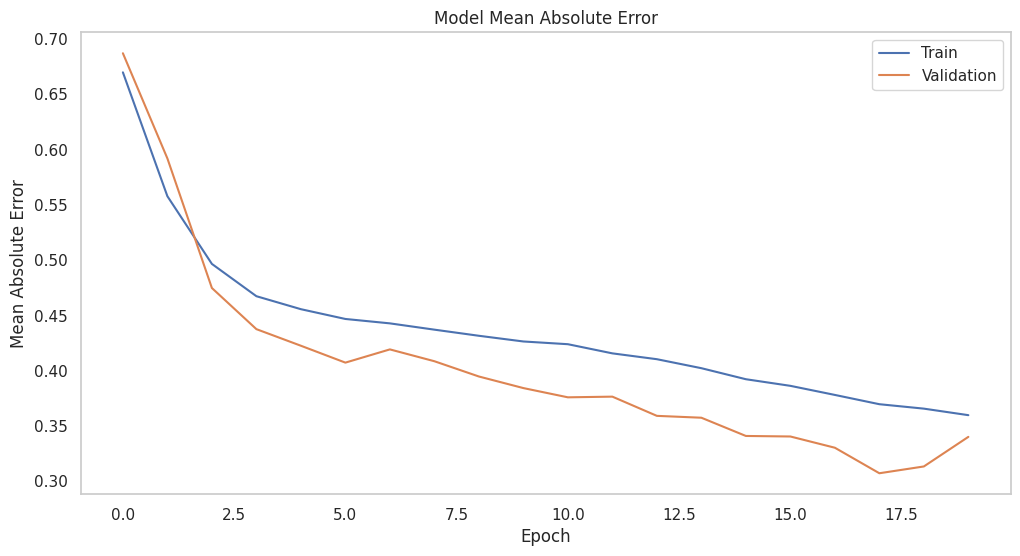

In [152]:
bidirectional_lstm_model = tf.keras.models.Sequential([
    Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(12, len(train_df.columns)), kernel_regularizer=l2(0.001))),
    tf.keras.layers.Dropout(0.2),
    Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    tf.keras.layers.Dropout(0.2),
    Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, kernel_regularizer=l2(0.001))
])

bidirectional_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                                metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the bidirectional LSTM model
history_bidirectional_lstm = bidirectional_lstm_model.fit(w1.train, epochs=20,
                                                        validation_data=w1.val,
                                                        callbacks=[reduce_lr])

# Evaluate the bidirectional LSTM model
val_performance['Bidirectional_LSTM'] = bidirectional_lstm_model.evaluate(w1.val, return_dict=True)
performance['Bidirectional_LSTM'] = bidirectional_lstm_model.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Bidirectional_LSTM']}")
print(f"Test performance: {performance['Bidirectional_LSTM']}")

plot_training_history(history_bidirectional_lstm)


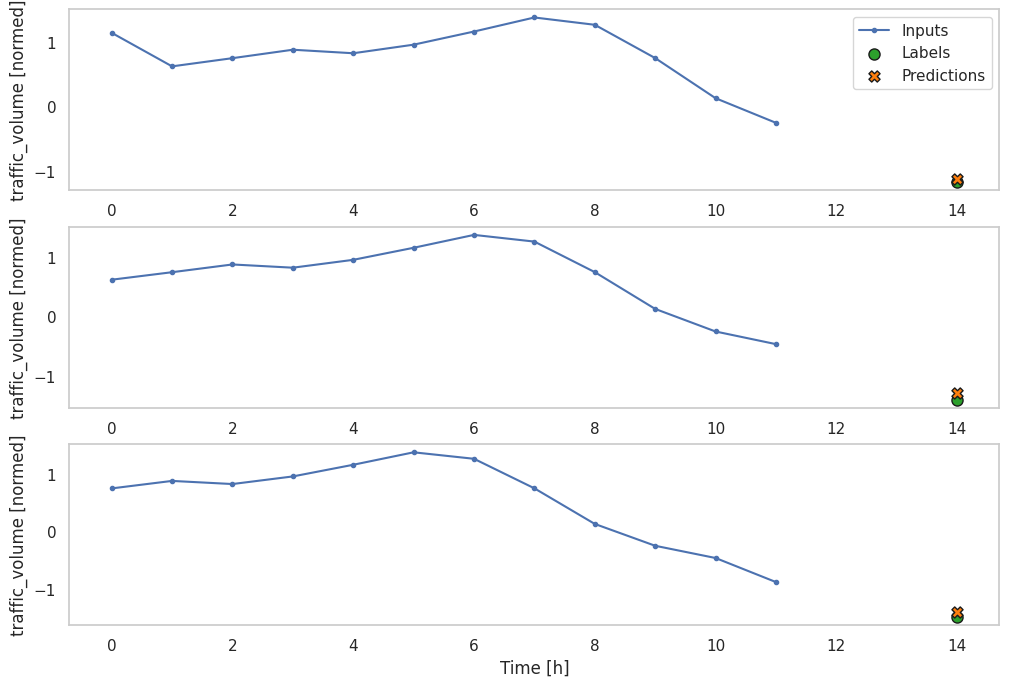

In [154]:
w1.plot(bidirectional_lstm_model)


**Significant change and lots of improvement, but I  lets try CNNs with LSTM**

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 1.1994 - mean_absolute_error: 0.8873 - val_loss: 0.8924 - val_mean_absolute_error: 0.7679 - learning_rate: 1.0000e-04
Epoch 2/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.8963 - mean_absolute_error: 0.7556 - val_loss: 0.5453 - val_mean_absolute_error: 0.5625 - learning_rate: 1.0000e-04
Epoch 3/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.5608 - mean_absolute_error: 0.5459 - val_loss: 0.3958 - val_mean_absolute_error: 0.4383 - learning_rate: 1.0000e-04
Epoch 4/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.5292 - mean_absolute_error: 0.5336 - val_loss: 0.3842 - val_mean_absolute_error: 0.4406 - learning_rate: 1.0000e-04
Epoch 5/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.5173 - mean_absolute_error: 0.5299 - val_loss: 0.3673 - val_mean_absolute_error: 0.4322 - learning_rate: 1.0000e-04
Epoch 6/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.4780 - mean_absolute_error: 0.5040 

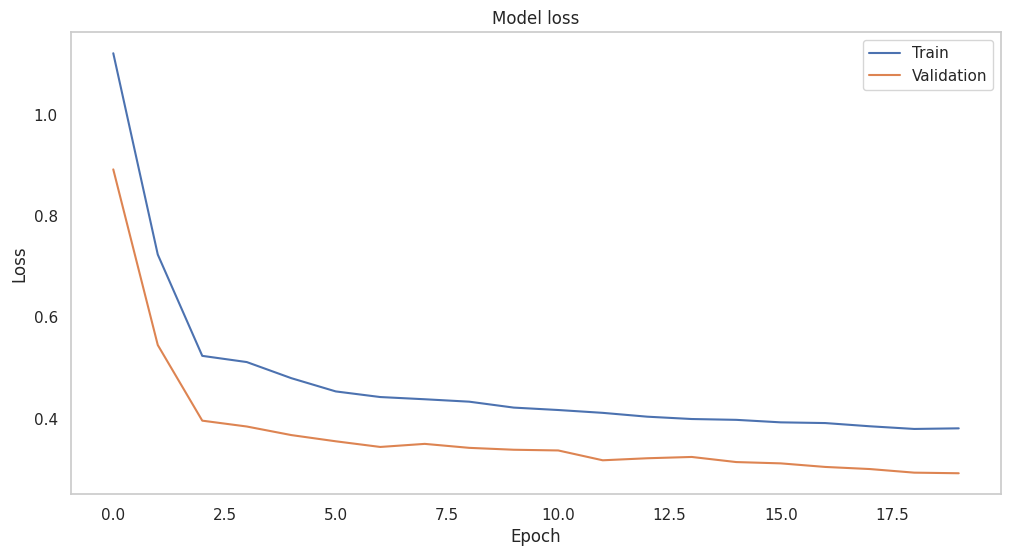

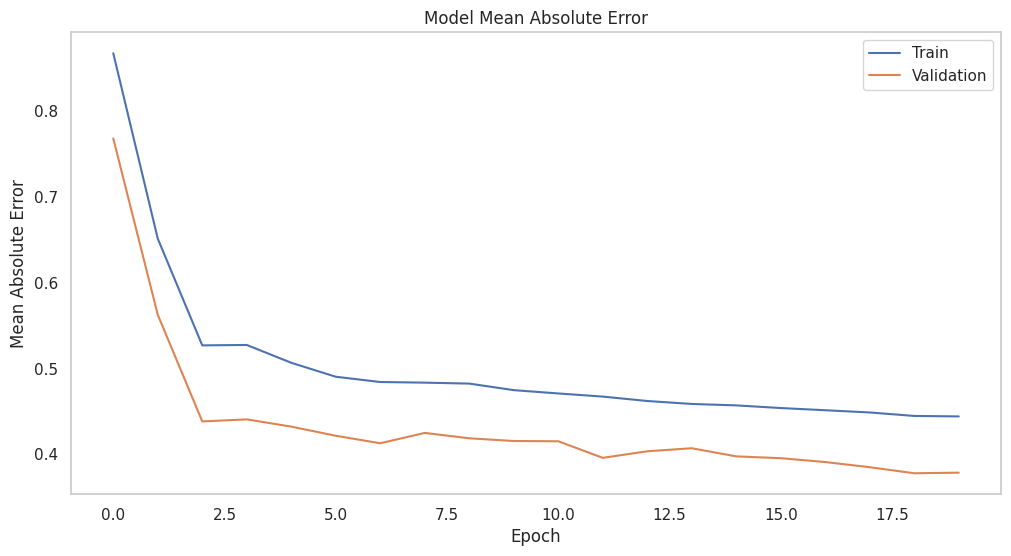

In [153]:
conv_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(12, len(train_df.columns))),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Reshape((4, 16)),  # Reshape to match LSTM input
    tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, kernel_regularizer=l2(0.001))
])

conv_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the 1D Convnet + LSTM model
history_conv_lstm = conv_lstm_model.fit(w1.train, epochs=20,
                                        validation_data=w1.val,
                                        callbacks=[reduce_lr])

# Evaluate the 1D Convnet + LSTM model
val_performance['Conv_LSTM'] = conv_lstm_model.evaluate(w1.val, return_dict=True)
performance['Conv_LSTM'] = conv_lstm_model.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Conv_LSTM']}")
print(f"Test performance: {performance['Conv_LSTM']}")

plot_training_history(history_conv_lstm)


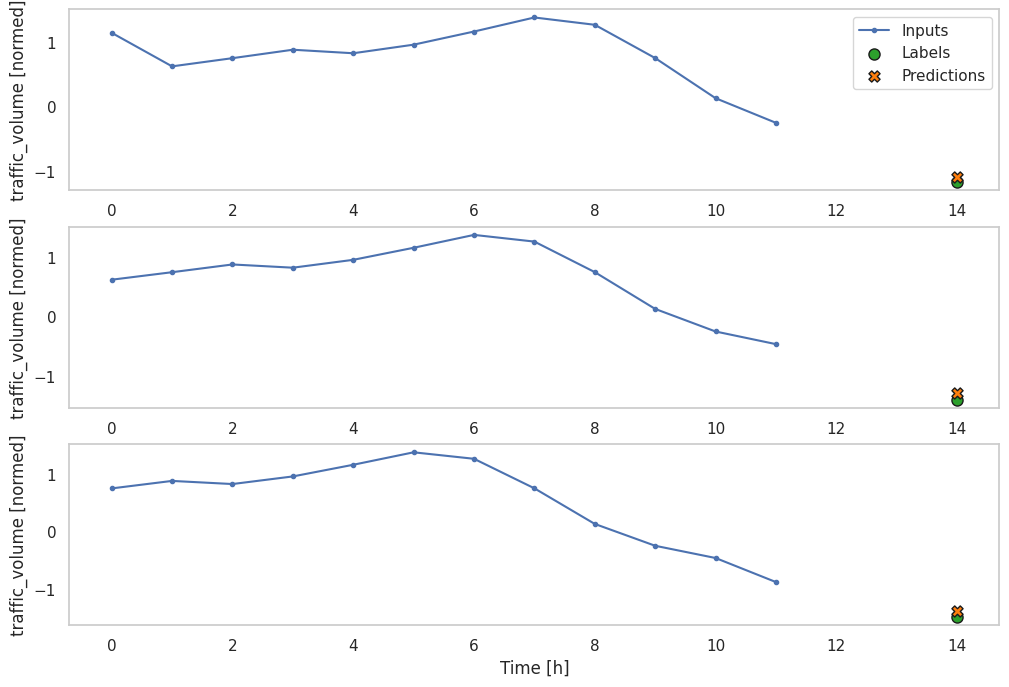

In [155]:
w1.plot(conv_lstm_model)

**improvement from lstm rnn, but not from the birenctional RNNs**

**Lets try 1D convolutional neural network (ConvNet) combined with Gated Recurrent Units (GRUs)**

Epoch 1/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.2855 - mean_absolute_error: 0.9062 - val_loss: 1.0734 - val_mean_absolute_error: 0.8423 - learning_rate: 1.0000e-04
Epoch 2/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.1657 - mean_absolute_error: 0.8810 - val_loss: 0.7075 - val_mean_absolute_error: 0.6308 - learning_rate: 1.0000e-04
Epoch 3/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.8907 - mean_absolute_error: 0.7213 - val_loss: 0.4861 - val_mean_absolute_error: 0.4696 - learning_rate: 1.0000e-04
Epoch 4/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.6993 - mean_absolute_error: 0.6086 - val_loss: 0.4599 - val_mean_absolute_error: 0.4793 - learning_rate: 1.0000e-04
Epoch 5/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.6211 - mean_absolute_error: 0.5655 - val_loss: 0.4160 - val_mean_absolute_error: 0.4401 - learning_rate: 1.0000e-04
Epoch 6/20
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.5829 - mean_absolute_error: 0.5456 

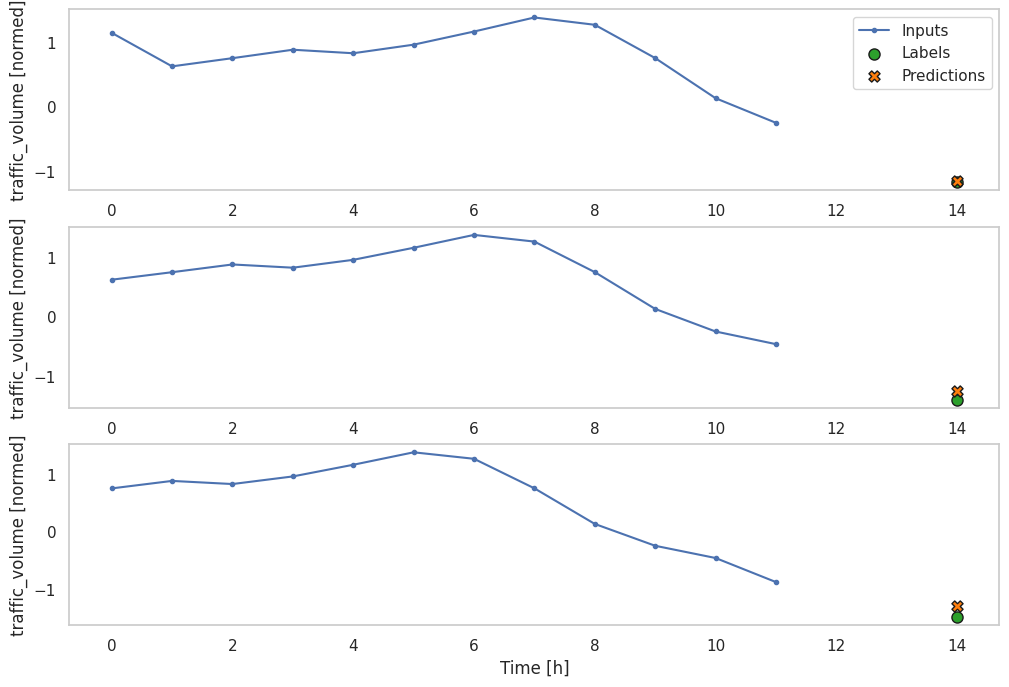

In [158]:
# Define the 1D ConvNet + GRU model
conv_gru_model = tf.keras.models.Sequential([
    # 1D Convolutional layers for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(12, len(train_df.columns))),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Reshape((4, 16)),  # Adjust the shape to fit into GRU layer
    # GRU layers for capturing temporal dependencies
    GRU(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    GRU(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=l2(0.001))
])

# Compile the model
conv_gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Training the 1D ConvNet + GRU model
history_conv_gru = conv_gru_model.fit(w1.train, epochs=20,
                                      validation_data=w1.val,
                                      callbacks=[reduce_lr])

# Evaluate the 1D ConvNet + GRU model
val_performance['Conv_GRU'] = conv_gru_model.evaluate(w1.val, return_dict=True)
performance['Conv_GRU'] = conv_gru_model.evaluate(w1.test, verbose=0, return_dict=True)

print(f"Validation performance: {val_performance['Conv_GRU']}")
print(f"Test performance: {performance['Conv_GRU']}")

w1.plot(conv_gru_model)


## **Predictions**

In [159]:
# Number of instances in the test set
test_set_length = len(test_df)
print(f"Test set length: {test_set_length}")

# Calculate the expected number of windows
total_window_size = 12 + 3
expected_windows = test_set_length - total_window_size + 1
print(f"Expected number of windows: {expected_windows}")

# Number of windows generated
test_windows = list(w1.test)
print(f"Number of windows generated: {len(test_windows)}")

Test set length: 5000
Expected number of windows: 4986
Number of windows generated: 156


In [160]:
# Make predictions on the test set
predictions = bidirectional_lstm_model.predict(w1.test)

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [162]:
# Extract the final prediction for each window
final_predictions = predictions[:, -1, 0]

In [164]:
unnormalized_predictions = scaler.inverse_transform(final_predictions.reshape(-1, 1)).flatten()

In [165]:
start_id = 35589
num_predictions = len(unnormalized_predictions)
end_id = start_id + num_predictions - 1
ids = np.arange(start_id, end_id + 1)

In [166]:
# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': ids,
    'prediction': unnormalized_predictions
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False, header=True)

# Verify the first few rows of the submission file
print(submission_df)

         id   prediction
0     35589  5362.599121
1     35590  5724.108398
2     35591  5910.516113
3     35592  6068.652832
4     35593  5997.607910
...     ...          ...
4981  40570  3574.618408
4982  40571  3230.269287
4983  40572  2878.738281
4984  40573  2488.347900
4985  40574  1997.407593

[4986 rows x 2 columns]
